### Desperately Seeking Silver

We are going to focus on the 2012 Presidential election.

We are going to focus on the 2012 Presidential election. Analysts like Nate Silver, Drew Linzer, and Sam Wang developed highly accurate models that correctly forecasted most or all of the election outcomes in each of the 50 states. We will explore how hard it is to recreate similarly successful models.

Outcomes:

1. To practice data manipulation with Pandas
2. To develop intuition about the interplay of **precision**, **accuracy**, and **bias** when making predictions
3. To better understand how election forecasts are constructed


In [1]:
"""   helper python script that contains the following :

- dark2_colors : a (rgb) color palette
- remove_border
    Minimize chartjunk by stripping out unnecesasry plot borders and axis ticks
- draw_state
    Automatically draws a filled shape representing the state in subplot.
- make_map
    Draw a cloropleth map, that maps data onto the United States
"""
%run hw2.py

In [25]:
%matplotlib inline

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
%precision 2

'%.2f'

In [4]:
from matplotlib.rcsetup import cycler

mpl.rc('figure', figsize=(10,6), dpi=150)
mpl.rc('axes', facecolor='white', 
       prop_cycle=cycler('color', dark2_colors ))
mpl.rc('lines', lw=2)
mpl.rc('patch', ec='white', fc=dark2_colors[0])
mpl.rc('font', size=14, family='StixGeneral')

In [5]:
# We are pretending to build our model 1 month before the election
import datetime
today = datetime.datetime(2012, 10, 2)
today

datetime.datetime(2012, 10, 2, 0, 0)

In [6]:
electoral_votes = pd.read_csv("../data/hw2_data/electoral_votes.csv").set_index('State')
electoral_votes.head()

,Votes
State,
California,55
Texas,38
New York,29
Florida,29
Illinois,20


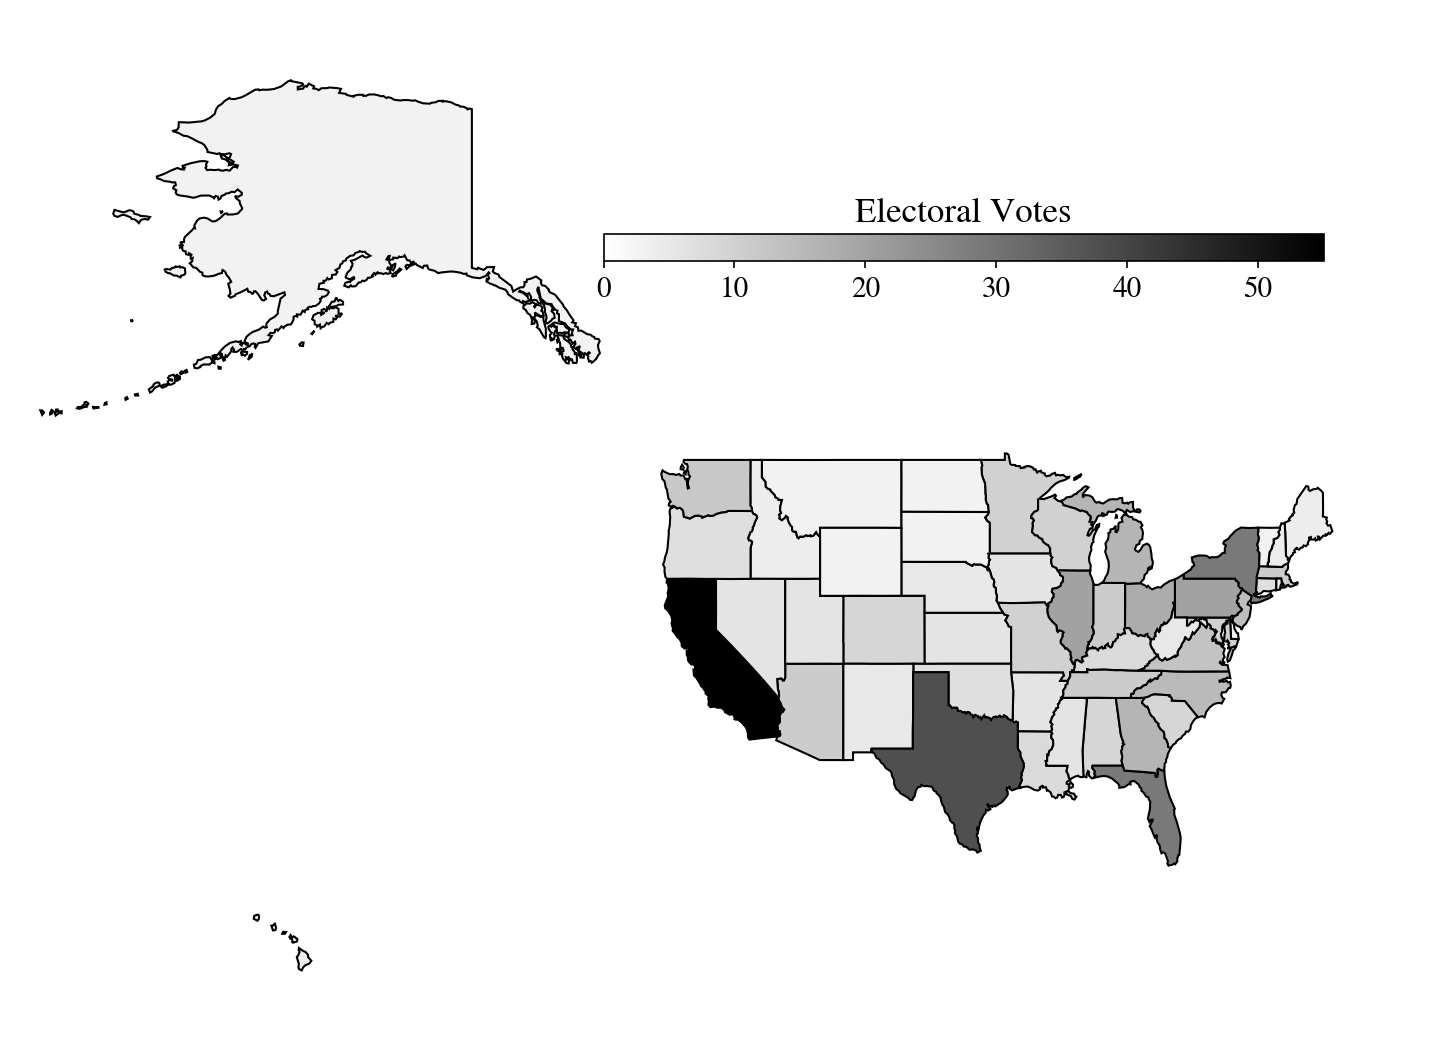

In [6]:
make_map(electoral_votes.Votes, "Electoral Votes")

### Question 1: Simulating elections

Our reference point:
[PredictWise](http://www.predictwise.com/results/2012/president)'s quite successful forecast, released on October 2, 2012.

PredictWise aggregated polling data and, for each state, estimated the probability that the Obama or Romney would win. Here are those estimated probabilities:


In [9]:
predictwise = pd.read_csv('../data/hw2_data/predictwise.csv').set_index('States')
predictwise.head()


,Obama,Romney,Votes
States,,,
Alabama,0.000,1.000,9
Alaska,0.000,1.000,3
Arizona,0.062,0.938,11
Arkansas,0.000,1.000,6
California,1.000,0.000,55


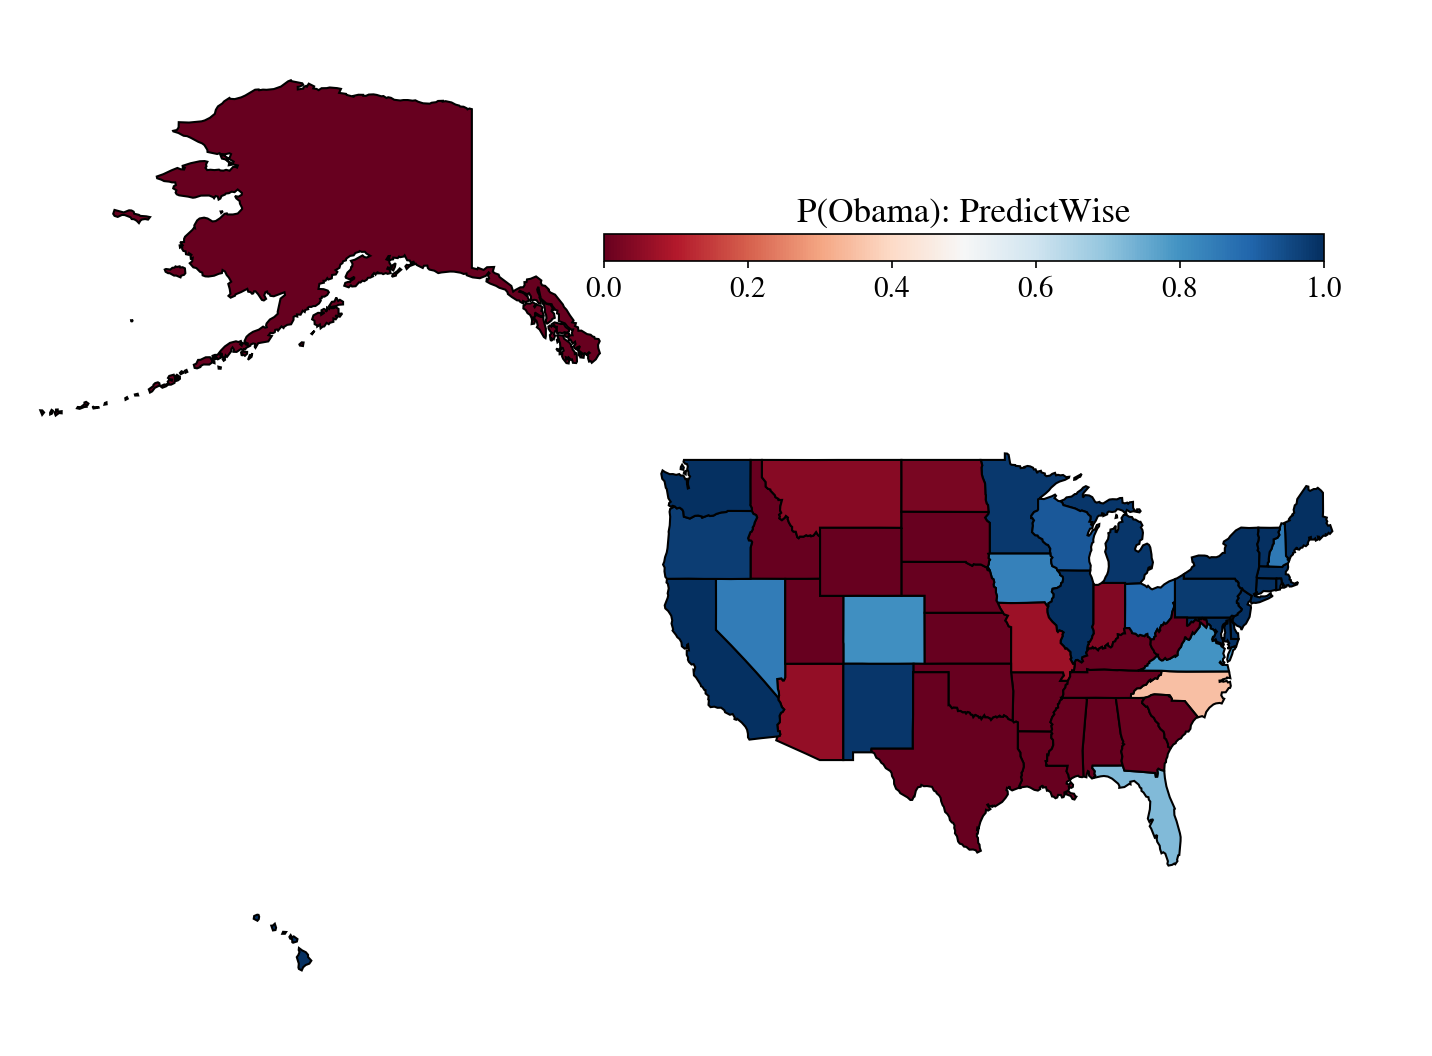

In [8]:
# Using make_map, plot the probability that
# Obama wins each state, according to this prediction.
make_map(predictwise.Obama, "P(Obama): PredictWise")

Even when we assume the win probabilities in each state are known, there is still uncertainty left in the election. We will use simulations from a simple probabilistic model to characterize this uncertainty.

We will assume that the outcome in each state is the result of an independent coin flip whose probability of coming up Obama is given by a Dataframe of state-wise win probabilities.

From these simulations, we will be able to make a prediction about the expected outcome of the election

In [7]:
"""
Function
--------
simulate_election

Inputs
------
model : DataFrame
    A DataFrame summarizing an election forecast. The dataframe has 51 rows -- one for each state and DC
    It has the following columns:
       Obama : Forecasted probability that Obama wins the state
       Votes : Electoral votes for the state
    The DataFrame is indexed by state (i.e., model.index is an array of state names)
    
n_sim : int
   Number of simulations to run
   
Returns
-------
results : Numpy array with n_sim elements
   Each element stores the number of electoral college votes Obama wins in each simulation.   
"""
def simulate_election(model, n_sim):
    # each column simulates a single outcome from the 50 states + DC
    # Obama wins the simulation if 
    # the random number is < the win probability
    simulations = np.random.uniform(size=(51, n_sim))
    obama_votes = (simulations < 
                   model.Obama.values.reshape(-1, 1)
                  ) * model.Votes.values.reshape(-1, 1)
    # summing over rows gives the total electoral votes 
    # for each simulation
    return obama_votes.sum(axis=0)


In [10]:
predictwise.Obama.values.reshape(-1,1)[:5]

array([[0.   ],
       [0.   ],
       [0.062],
       [0.   ],
       [1.   ]])

The following cells takes the necessary DataFrame for the Predictwise data, and runs 10000 simulations. 

We use the results to compute the probability, according to this predictive model, that Obama **wins** the election (i.e., the probability that he receives `269 or more` electoral college votes)

In [14]:
result = simulate_election(predictwise, 10000)
result

array([309, 332, 337, ..., 322, 338, 326])

In [16]:
#compute the probability of an Obama win, given this simulation
print((result >= 269).mean())

0.996


In [11]:
"""
Function
--------
plot_simulation

Inputs
------
simulation: Numpy array with n_sim (see simulate_election) elements
   Each element stores the number of electoral college votes 
   Obama wins in each simulation.
"""
def plot_simulation(simulation):    
    plt.hist(simulation, bins=np.arange(240, 375, 1), 
             label='simulations', align='left', density=True)
    plt.axvline(332, 0, .5, color='r', 
                linestyle='--', label='Actual Outcome')
    plt.axvline(269, 0, .5, color='k', 
                linestyle='--', label='Victory Threshold')
    
    p05 = np.percentile(simulation, 5.)
    p95 = np.percentile(simulation, 95.)
    iq = int(p95 - p05)
    
    pwin = ((simulation >= 269).mean() * 100)
    
    plt.title("Chance of Obama Victory: {:.1f}%, Spread: {} votes".format(
    pwin, iq))
    plt.legend(frameon=False, loc='upper left')
    plt.xlabel("Obama Electoral College Votes")
    plt.ylabel("Probability")
    remove_border()

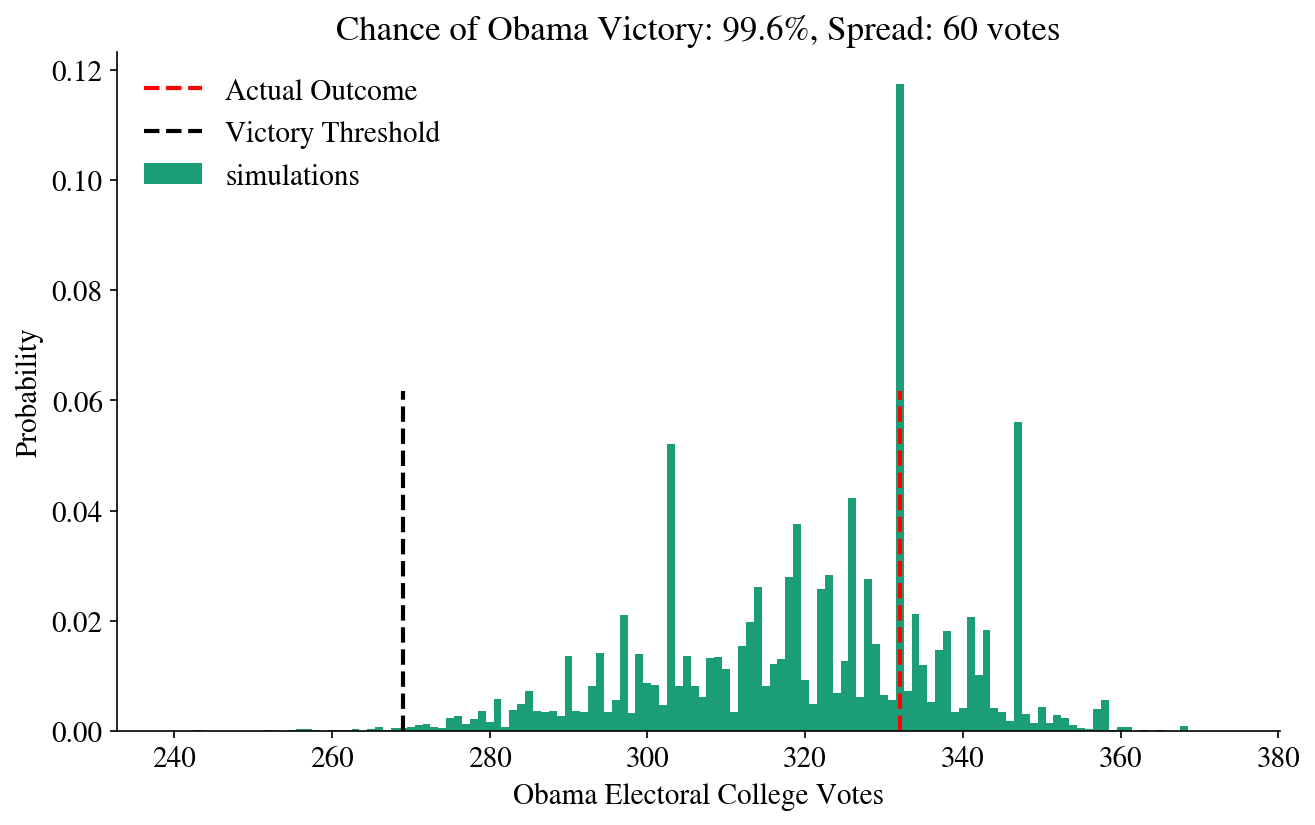

In [48]:
plot_simulation(result)

---

### Evaluating and Validating our Forecast

The goal of creating a probabilistic predictive model is to simultaneously  :

- make a forecast
- and give an estimate of how certain we are about it.

To trust our prediction or our reported level of uncertainty, the model needs to be **correct**.

A model is **correct** if it honestly accounts for `all of the mechanisms of variation` in the system we're forecasting.

The above histogram shows a hypothesis test.
It approximates the predictive distribution of election outcomes (in terms of electoral votes) `assuming our model for the election is true`.


---

### Gallup Party Affiliation Poll

We try to estimate our own win probabilities to plug into our predictive model, starting with a simple forecast model.

We will try to predict the outcome of the election based the estimated proportion of people in each state who identify with one political party or the other.

**Gallup** measures the political leaning of each state, based on asking random people which party they identify or affiliate with. 

Here's the [data](http://www.gallup.com/poll/156437/heavily-democratic-states-concentrated-east.aspx#2) they collected from January-June of 2012:

In [12]:
gallup_2012=pd.read_csv("../data/hw2_data/g12.csv").set_index('State')
gallup_2012["Unknown"] = 100 - gallup_2012.Democrat - gallup_2012.Republican
gallup_2012.head()

,Democrat,Republican,Dem_Adv,N,Unknown
State,,,,,
Alabama,36.0,49.6,-13.6,3197,14.4
Alaska,35.9,44.3,-8.4,402,19.8
Arizona,39.8,47.3,-7.5,4325,12.9
Arkansas,41.5,40.8,0.7,2071,17.7
California,48.3,34.6,13.7,16197,17.1


This survey can be used to predict the outcome of each State's election.

The simplest forecast model assigns 100% probability that the state will vote for the majority party.

In [15]:
"""
Function
--------
simple_gallup_model

A simple forecast that predicts an Obama (Democratic) victory with
0 or 100% probability, depending on whether a state
leans Republican or Democrat.

Inputs
------
gallup : DataFrame
    The Gallup dataframe above

Returns
-------
model : DataFrame
    A dataframe with the following column
    * Obama: probability that the state votes for Obama. 
    All values should be 0 or 1
    model.index should be set to gallup.index 
    (should be indexed by state name)
    
Examples
---------
>>> simple_gallup_model(gallup_2012).ix['Florida']
Obama    1
Name: Florida, dtype: float64
>>> simple_gallup_model(gallup_2012).ix['Arizona']
Obama    0
Name: Arizona, dtype: float64
"""

def simple_gallup_model(gallup):
    data = ((gallup.Dem_Adv > 0).astype(float))
    return pd.DataFrame(data=data).rename(columns={'Dem_Adv':'Obama'})
# check the code
simple_gallup_model(gallup_2012).head()

,Obama
State,
Alabama,0.0
Alaska,0.0
Arizona,0.0
Arkansas,1.0
California,1.0


In [20]:
# we run the simulation with this model, and plot it.
model = simple_gallup_model(gallup_2012)
# add the number of electoral votes perstate as a column
model = model.merge(electoral_votes, on='State')
prediction = simulate_election(model, 10000)
prediction

array([334, 334, 334, ..., 334, 334, 334])

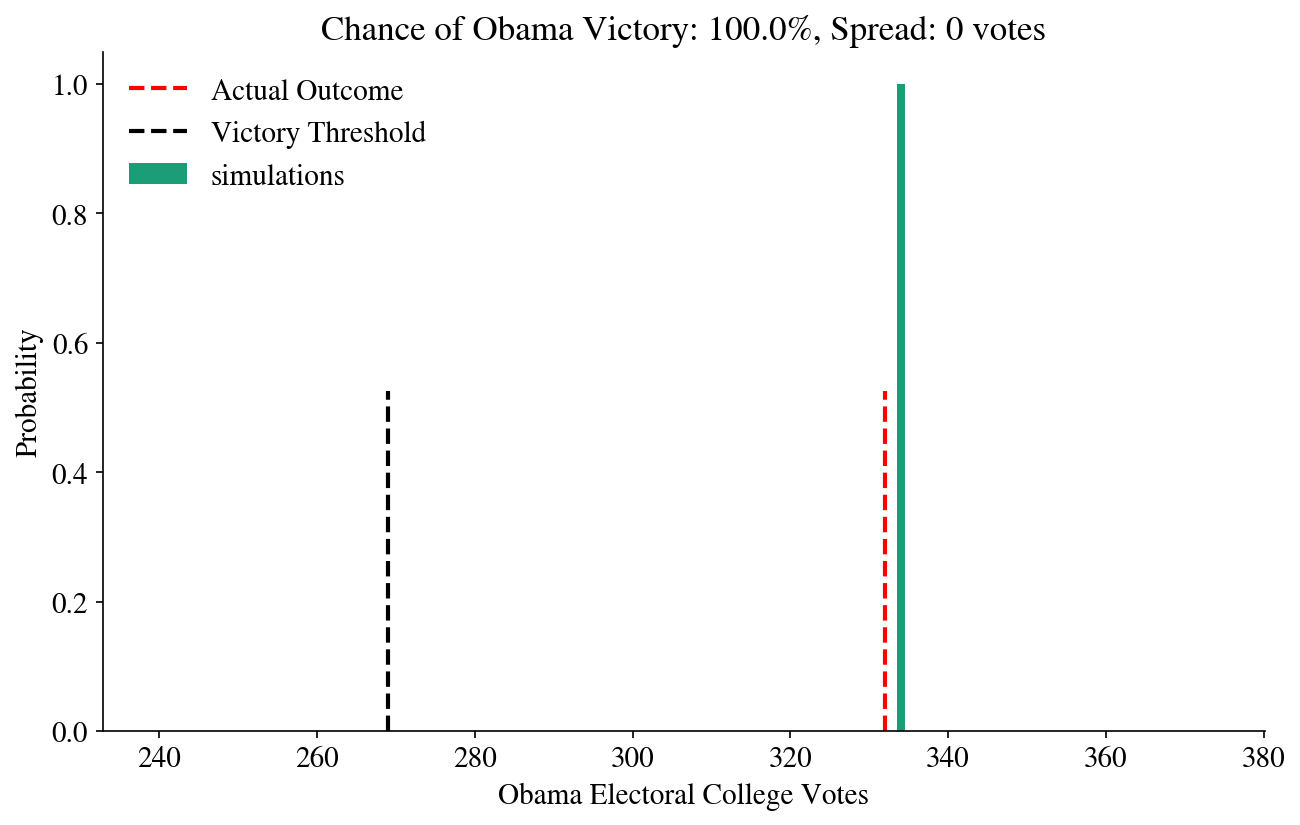

In [21]:
plot_simulation(prediction)

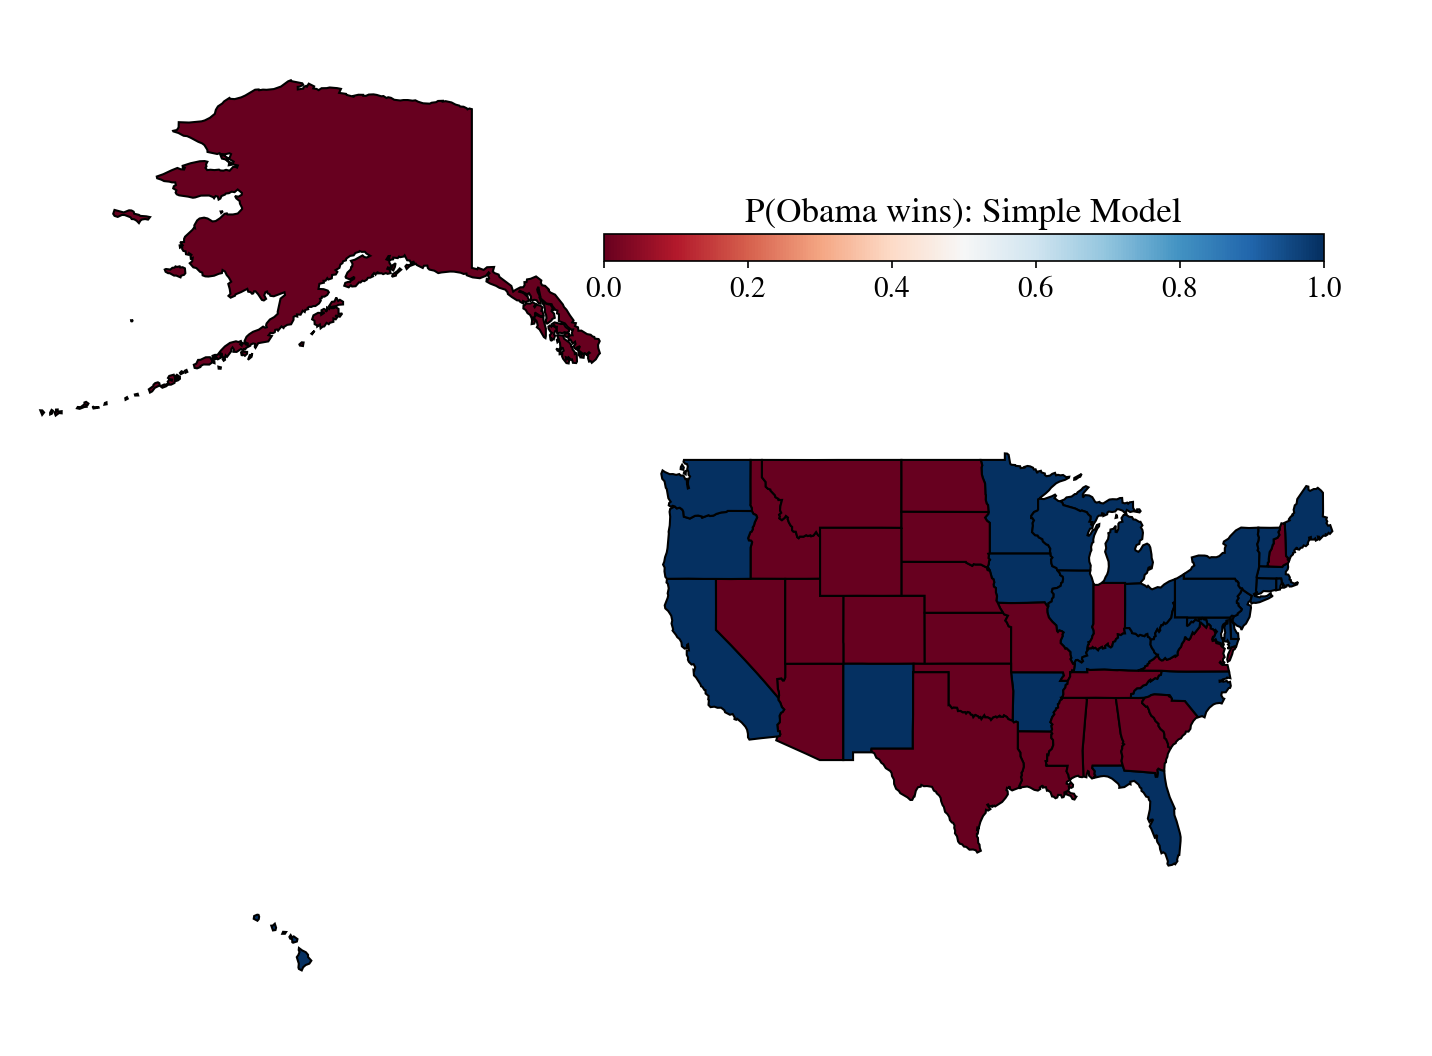

In [22]:
make_map(model.Obama, 'P(Obama wins): Simple Model')

### Model Validation
*`Does the evidence contradict the predictive model?`*

We do not predict the exactly correct result (red line). According to the predictive model (which presumes zeor uncertainty), the true outcome has probability 0. 

Thus, the evidence contradicts the predictive model, and we should reject it.


### Adding Polling Uncertainty to the Predictive Model

The model above is brittle -- it includes no accounting for uncertainty, and thus makes predictions with 100% confidence. 

There are numerous sources of `uncertainty` in estimating election outcomes from a poll of affiliations.

The most obvious source of error in the Gallup data is the `finite sample size`.

***How much uncertainty does this introduce?***

On their [webpage](http://www.gallup.com/poll/156437/heavily-democratic-states-concentrated-east.aspx#2) discussing these data, Gallup notes that the `sampling error` for the states is between 3 and 6%, with it being `3%` for most states.

- Use Gallup's estimate of 3% to build a Gallup model with some uncertainty. 

Assume that the `Dem_Adv` column represents the `mean of a Gaussian`, whose `standard deviation` is **3%**.

The probability that a sample from a Gaussian with mean $\mu$ and standard deviation $\sigma$ exceeds a threhold $z$ can be found using the the Cumulative Distribution Function (CDF) of a Gaussian:

$$ CDF(z) = \frac1{2}\left(1 + {\rm erf}\left(\frac{z - \mu}{\sqrt{2 \sigma^2}}\right)\right) $$ 

In [38]:
"""
Function
--------
uncertain_gallup_model

predicts an Obama (Dem) victory if the random variable drawn
from a Gaussian with mean Dem_Adv and standard deviation 3% is >0

Inputs
------
gallup : DataFrame
    The Gallup dataframe above

Returns
-------
model : DataFrame
    A dataframe with the following column
     * Obama: probability that the state votes for Obama.
    model.index should be set to gallup.index 
    (that is, it should be indexed by state name)
"""
from scipy.special import erf

def uncertain_gallup_model(gallup):
    sigma = 3
    prob =  .5 * (1 + erf(gallup.Dem_Adv / np.sqrt(2 * sigma**2)))
    return pd.DataFrame(data=prob, index=gallup.index).rename(columns={'Dem_Adv':'Obama'})
# test the code
uncertain_gallup_model(gallup_2012).head()

,Obama
State,
Alabama,0.000003
Alaska,0.002555
Arizona,0.006210
Arkansas,0.592249
California,0.999998


In [39]:
# construct the model by estimating the probabilities
model = uncertain_gallup_model(gallup_2012)
# add the number of electoral votes perstate as a column
model = model.merge(electoral_votes, on='State')

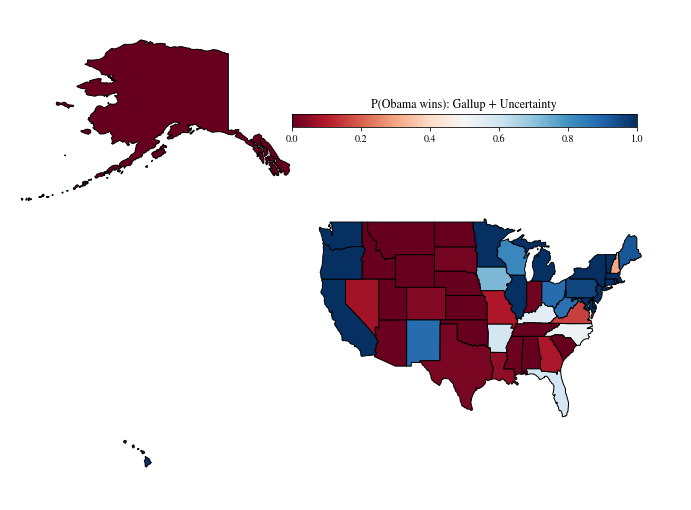

In [40]:
# we plot a map of these probabilities, 
make_map(model.Obama, "P(Obama wins): Gallup + Uncertainty")

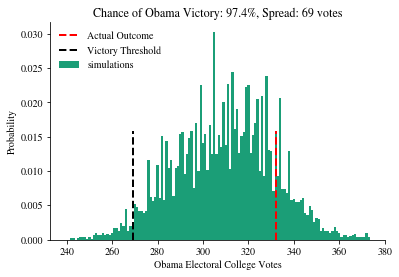

In [31]:
# we run the simulation, and display the results
prediction = simulate_election(model, 10000)
plot_simulation(prediction)

### Model Validation
*`Does the evidence contradict the predictive model?`*

The predictive distribution is consistent with the real data ; the real outcome seems like a typical outcome according to the model. 

The `accuracy` is not very good as the center of the distribution falls fairly far from the observed outcome, but the `precision` is only marginally worse than in the predictwise case.
